# Task Description

In [ ]:
# The task would be to test a long-only stock-based carry/value strategy.

# Carry strategy in stocks would be to long high dividend yield stocks and short the reverse (in this case no need to do short).
# Whole value strategy you should be familiar with.

# Carry trade in rate hike periods work pretty well (for fx especially). We are interested in whether the same hold for value. 
# The underlying assets would be S&P 500 stocks.

# Please take into account that some companies do stock repurchase instead of cash dividend.
# You could try to find adjusted dividend yield data. Time horizon is up to you, but keep in mind potential survivorship bias.
# It might be interesting to check the strategy performance during different periods. 
# Remember to make the backtest a way that they could be implemented (not longing 100 stocks at the same time). 
# Have a nice night and good luck with your presentation on Monday.

# Setup

## Load Packages

In [1]:
#### Import required Packages ####
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scipy as sp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # to calculate the MSE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from statsmodels.graphics.tsaplots import plot_acf # To produce ACF plots
from statsmodels.graphics.tsaplots import plot_pacf # To produce PACF plots
from statsmodels.tsa.seasonal import seasonal_decompose # To decompose Seasons
from statsmodels.tsa.stattools import adfuller, kpss # Tests for Stationarity
from statsmodels.tsa.ar_model import AutoReg # To produce AR models
from statsmodels.stats.anova import anova_lm # To use ANOVA (compare nested models)
from statsmodels.tsa.arima.model import ARIMA # To build ARMA & ARIMA Models
import statsmodels.stats.diagnostic as dg # To get Breusch-Godfrey Test
from statsmodels.stats.stattools import durbin_watson



from datetime import datetime # to transform variables into datetime objects
import math # simple math functions
from math import sqrt # square root function
import statistics # descriptive statistics library
import scipy.stats as stats # descriptive statistics library from scipy
import matplotlib.dates as mdates # date formatting
from matplotlib.collections import PolyCollection, LineCollection # better plot options

C:\Users\Corinne Vogel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Corinne Vogel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [ ]:
def h(x, y): 
    return x * y                             
vecmult = np.vectorize(h)    # Use pd.DataFrame(vecmult(A,B)) to get df of elementwise multiplication

## Plotstyle

In [2]:
# Seaborn plot style ticks to have nicer looking plots
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Approach 2 --> running 12-month avg of carry signal --> weekly rebalance

In [ ]:
# the approach is as follows: 
# 1. take a moving average of the 12 month previous carry signal, ignoring the most recent month
# 2. for each month calculate the 10 stocks considered for the long strategy
# 3. calculate the PF return
# 4. take into account the transaction costs

In [3]:
# Loading Data (takes some time)

div = pd.read_excel("02_Data_clean/SPX_div_clean_Nick.xlsx", parse_dates=["Date"])
ret = pd.read_excel("02_Data_clean/SPX_px_clean_Nick.xlsx", parse_dates=["Date"])

# safe the div as divv in case we need it later
divv = div 

# reset the index to be a date
div = div.set_index(['Date'])
ret = ret.set_index(['Date'])

# Check
# print(type(div))
# print(div.dtypes)
# print(type(ret))
# print(ret.dtypes)

In [4]:
# create 12-month running avg of carry signal (i.e., div yield) lagged by one month

for i in range(52, len(div.index)-4):
    x = div.iloc[i-52:i,:].mean()
    div.iloc[i+4,:] = x


In [5]:
# in a first step we create a dataframe which we will fill with the weights of the carry strategy each month
### Important ### for carry we should use the (expected) dividend yield minus the riskfree ### Important ###
cols = divv.columns[1:]
rows = divv.iloc[:,0]

weights = pd.DataFrame(index = rows, columns = (cols))

In [6]:
# create weights dataframe

for i in div.index:
    x = div.loc[i,:].nlargest(10)
    for j in div.columns:
        if j in x.index:
            weights.loc[i,j] = 0.1
        else:
            weights.loc[i,j] = 0

weights

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,PTC UQ Equity,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-07,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-14,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-21,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-28,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-11,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-18,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
weighted_ret = weights.copy()

for i in range(52+5, len(weights.index)):
    for j in range(len(weights.columns)):
        weighted_ret.iloc[i,j] = weights.iloc[i-1,j]*ret.iloc[i,j]
        

weighted_ret['PF_ret'] = 0
weighted_ret


,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity,PF_ret
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-07,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-14,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-21,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-28,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,-0.0,-0.001754,NaN,0.0,NaN,-0.0,-0.0,0.0,0.0,-0.0,...,-0.0,NaN,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,0
2022-11-11,0.0,0.00923,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0
2022-11-18,0.0,0.002046,NaN,0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0


In [ ]:
# # calculate PF returns (takes ages)

# for i in weighted_ret.index[52+4:]:
#     for j in weighted_ret.columns:
#         weighted_ret.loc[i,j] = weighted_ret.loc[i,j]*ret.loc[i,j]
        
# weighted_ret['PF_ret'] = 0
# weighted_ret

# # first 52 weeks have no return calculated since they are only used for PF weights creation in 2000-12

In [8]:
# now we sum over each row to calculate the PF return and put it in the respective columns

for i in weighted_ret.index[52+5:]:
    weighted_ret.loc[i,'PF_ret'] = weighted_ret.loc[i,:].sum()

weighted_ret

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity,PF_ret
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-01-07,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-01-14,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-01-21,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-01-28,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,-0.0,-0.001754,NaN,0.0,NaN,-0.0,-0.0,0.0,0.0,-0.0,...,-0.0,NaN,NaN,NaN,-0.0,NaN,NaN,NaN,NaN,0.006965
2022-11-11,0.0,0.00923,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.013816
2022-11-18,0.0,0.002046,NaN,0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-0.001155


In [ ]:
weighted_ret.iloc[52+5:,500].agg(lambda x: ((1+x).prod()-1))

In [ ]:
x = [i for i in weighted_ret['PF_ret'] if i > 0.05]
x

In [ ]:
y = [i for i in weighted_ret['PF_ret'] if i < -0.05]
y

In [ ]:
sb.scatterplot(y = weighted_ret['PF_ret'], x = weighted_ret.index, s = 5)

In [ ]:
sb.lineplot(y = weighted_ret['PF_ret'], x = weighted_ret.index)

In [ ]:
weighted_ret.head(60)

In [9]:
x = 1
for i in weighted_ret.iloc[57:,500]:
    #print(i)
    x = (1+i)*x
print(x)
PF_return_annual = (x**(52/225))-1
PF_return_annual

# yielding an annual return of 33%

3.4790848048987084


0.3339470202829964

In [ ]:
weighted_ret.iloc[52:,500].shape

In [ ]:
PF_mean = weighted_ret['PF_ret'].mean()
PF_mean

In [ ]:
PF_std = weighted_ret['PF_ret'].std() * (52)**0.5

In [ ]:
(PF_return_annual - 0.01)/PF_std

# Approach 3 --> running 12-month avg of carry signal --> monthly rebalanced

In [18]:
# Loading Data (takes some time)

div = pd.read_excel("02_Data_clean/SPX_div_clean_Nick.xlsx", parse_dates=["Date"])
ret = pd.read_excel("02_Data_clean/SPX_px_clean_Nick.xlsx", parse_dates=["Date"])

# safe the div as divv in case we need it later
divv = div 

# reset the index to be a date
div = div.set_index(['Date'])
ret = ret.set_index(['Date'])

# Check
# print(type(div))
# print(div.dtypes)
# print(type(ret))
# print(ret.dtypes)

In [19]:
# Resample monthly dividends (always take the last of the month to be the monthly div yield)
mtl_div = div.resample("M").ffill()
rett = ret.resample("M").agg(lambda x: ((1+x).prod()-1))
#print(mtl_div)
#print(rett)

In [20]:
# create 12-month running avg of carry signal (i.e., div yield) lagged by one month

for i in range(12, len(div.index)-1):
    x = div.iloc[i-12:i,:].mean()
    div.iloc[i+1,:] = x


In [21]:
# in a first step we create a dataframe which we will fill with the weights of the carry strategy each month

cols = divv.columns[1:]
rows = divv.iloc[:,0]

weights = pd.DataFrame(index = rows, columns = (cols))
weights = weights.resample("M").ffill()

In [22]:
# create weights dataframe

for i in mtl_div.index:
    x = mtl_div.loc[i,:].nlargest(10)
    for j in mtl_div.columns:
        if j in x.index:
            weights.loc[i,j] = 0.1
        else:
            weights.loc[i,j] = 0

weights

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,PTC UQ Equity,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-02-29,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-04-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0,0,0,0,0,0,0.1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-31,0,0,0,0,0,0,0.1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# # cut before being able to calculate

# des_weights = weights.loc['2001-01-31':'2022-12-02',:]
# ret_2 = rett.loc['2001-01-31':'2022-12-02',:]
# weighted_ret = pd.DataFrame(vecmult(des_weights, ret_2))
# weighted_ret

# # gid bimir was falsches

In [23]:
# calculate PF returns (takes some time) 

### I HAD TO LAG THE WEIGHTS AND RETURNS AGAIN ###

weighted_ret = weights.copy()

for i in range(12+2, len(weights.index)):
    for j in range(len(weights.columns)):
        weighted_ret.iloc[i,j] = weights.iloc[i-1,j]*rett.iloc[i,j]
        

weighted_ret['PF_ret'] = 0
weighted_ret

# first 12 months have no return calculated since they are only used for PF weights creation in 2001

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity,PF_ret
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-01-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-02-29,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-04-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2022-09-30,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.012208,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0
2022-10-31,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# # KEEP AS BACKUP


# # calculate PF returns (takes some time)
# weighted_ret = weights
# runner = 12

# for i in weights.index[12+1:]:
#     for j in weights.columns:
#         weighted_ret.loc[i,j] = weighted_ret.loc[i,j]*rett.loc[i,j]
#     runner += 1
        
# weighted_ret['PF_ret'] = 0
# weighted_ret

# # first 12 months have no return calculated since they are only used for PF weights creation in 2001

In [24]:
# now we sum over each row to calculate the PF return and put it in the respective columns

for i in weighted_ret.index[12+1:]:
    weighted_ret.loc[i,'PF_ret'] = weighted_ret.loc[i,:].sum()

weighted_ret

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity,PF_ret
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-01-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-02-29,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-03-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-04-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034414
2022-09-30,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.012208,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.188427
2022-10-31,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136505


In [ ]:
sb.lineplot(y = weighted_ret['PF_ret'], x = weighted_ret.index)

In [ ]:
x = [i for i in weighted_ret['PF_ret'] if i > 0.05]
len(x)

In [ ]:
x = [i for i in weighted_ret['PF_ret'] if i < -0.05]
len(x)

In [25]:
x = 1
for i in weighted_ret.iloc[12+1:,500]:
    #print(i)
    x = (1+i)*x
PF_return_annual = (x**(12/(264)))-1
PF_return_annual

# yielding an annual return of 12%

0.11898473772171214

# Approach 4 --> running 12-month avg of carry signal --> quarterly rebalanced

In [34]:
# Loading Data (takes some time)

div = pd.read_excel("02_Data_clean/SPX_div_clean_Nick.xlsx", parse_dates=["Date"])
ret = pd.read_excel("02_Data_clean/SPX_px_clean_Nick.xlsx", parse_dates=["Date"])

# safe the div as divv in case we need it later
divv = div 

# reset the index to be a date
div = div.set_index(['Date'])
ret = ret.set_index(['Date'])

# Check
# print(type(div))
# print(div.dtypes)
# print(type(ret))
# print(ret.dtypes)

In [35]:
# Resample monthly dividends (always take the last of the month to be the monthly div yield)
mtl_div = div.resample("Q").ffill()
rett = ret.resample("Q").agg(lambda x: ((1+x).prod()-1))
#print(mtl_div)
#print(rett)

In [36]:
# create quarter-year running avg of carry signal (i.e., div yield) lagged by one quartal

for i in range(4, len(div.index)-1):
    x = div.iloc[i-4:i,:].mean()
    div.iloc[i+1,:] = x


In [37]:
# in a first step we create a dataframe which we will fill with the weights of the carry strategy each month

cols = divv.columns[1:]
rows = divv.iloc[:,0]

weights = pd.DataFrame(index = rows, columns = (cols))
weights = weights.resample("Q").ffill()

In [38]:
# create weights dataframe

for i in mtl_div.index:
    x = mtl_div.loc[i,:].nlargest(10)
    for j in mtl_div.columns:
        if j in x.index:
            weights.loc[i,j] = 0.1
        else:
            weights.loc[i,j] = 0

weights

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,PTC UQ Equity,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-06-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-09-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,0.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-03-31,0.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-06-30,0.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# calculate PF returns (takes some time) 

### I HAD TO LAG THE WEIGHTS AND RETURNS AGAIN ###

weighted_ret = weights.copy()

for i in range(4+2, len(weights.index)):
    for j in range(len(weights.columns)):
        weighted_ret.iloc[i,j] = weights.iloc[i-1,j]*rett.iloc[i,j]
        

weighted_ret['PF_ret'] = 0
weighted_ret

# first 12 months have no return calculated since they are only used for PF weights creation in 2001

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity,PF_ret
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-06-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-09-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,0.00651,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.01665,0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0
2022-03-31,0.001989,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0
2022-06-30,-0.003161,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0


In [ ]:
weighted_ret.head(10)

In [40]:
# now we sum over each row to calculate the PF return and put it in the respective columns

for i in weighted_ret.index[4+1:]:
    weighted_ret.loc[i,'PF_ret'] = weighted_ret.loc[i,:].sum()

weighted_ret

,AEE UN Equity,ITT UN Equity,UN UN Equity,APD UN Equity,RDPL UN Equity,GOLD UN Equity,VZ UN Equity,CAT UN Equity,CVX UN Equity,KO UN Equity,...,QCOM UQ Equity,SPLS UQ Equity,XLNX UQ Equity,1519128D UQ Equity,NTAP UQ Equity,CTXS UQ Equity,9990253D UN Equity,0948669D UN Equity,CMCSK UQ Equity,PF_ret
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-03-31,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-06-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-09-30,0,0.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2000-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,0.00651,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.01665,0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.037585
2022-03-31,0.001989,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.108214
2022-06-30,-0.003161,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.081451


In [41]:
x = 1
for i in weighted_ret.iloc[4+2:,500]:
    #print(i)
    x = (1+i)*x
PF_return_annual = (x**(12/(264/4)))-1
PF_return_annual

# yielding an annual return of 41%

0.4108791051296119

## TC

In [42]:
# we start our weights at 13, and have a first return at 14

turnover_dict = {weighted_ret.index[5]: 1}

rows, cols = weighted_ret.shape
rows

for i in range (6, rows):
    total_turnover = 0
    for j in range(cols-1):
        act_weight = (1+ rett.iloc[i,j])/(1+ weighted_ret.iloc[i,500])*weights.iloc[i-1,j]
        des_weight = weights.iloc[i,j]
        total_turnover = total_turnover + abs(act_weight - des_weight)
    turnover_dict[weighted_ret.index[i]] = total_turnover
        
#turnover_dict

In [43]:
# create a turnover cost dataframe

turnover_df = pd.DataFrame.from_dict(turnover_dict, orient = 'index')
turnover_df = turnover_df * 0.002
turnover_df

,0
2001-03-31,0.002000
2001-06-30,0.000759
2001-09-30,0.001659
2001-12-31,0.002152
2002-03-31,0.001396
...,...
2021-12-31,0.000910
2022-03-31,0.001436
2022-06-30,0.000959
2022-09-30,0.001407


In [44]:
# calculate the PF returns --> insert a 0 at the top

PF_return = weighted_ret.iloc[5:,500]
PF_return.iloc[0] = 0
PF_return

Date
2001-03-31    0.000000
2001-06-30    0.035285
2001-09-30   -0.195292
2001-12-31   -0.015364
2002-03-31    0.139633
                ...   
2021-12-31    0.037585
2022-03-31    0.108214
2022-06-30   -0.081451
2022-09-30   -0.127475
2022-12-31    0.206418
Freq: Q-DEC, Name: PF_ret, Length: 88, dtype: float64

In [45]:
# calculate the PF returns after TC

total_ret = PF_return - turnover_df[0]
total_ret

Date
2001-03-31   -0.002000
2001-06-30    0.034526
2001-09-30   -0.196952
2001-12-31   -0.017516
2002-03-31    0.138237
                ...   
2021-12-31    0.036676
2022-03-31    0.106778
2022-06-30   -0.082410
2022-09-30   -0.128883
2022-12-31    0.204987
Freq: Q-DEC, Length: 88, dtype: float64

In [46]:
x = 1
for i in total_ret:
    #print(i)
    x = (1+i)*x
PF_return_annual = (x**(4/(88)))-1
PF_return_annual

# yielding an annual return of 8.5%

0.08466168328435764

## Adjust for TC --> weekly rebalancing

In [ ]:
# we have the weighted return DF with all the weights * R_s
# we have the desired weights called weights
# we have the PF return in the weighted return DF at 500 place
# now we need to create an array with the total turnover per month

In [ ]:
weights

In [ ]:
weighted_ret.head(60)

In [ ]:
weighted_ret.iloc[57,500]

In [10]:
# we start our weights at 13, and have a first return at 14

rett = ret.fillna(0)

turnover_dict = {weighted_ret.index[56]: 1}

rows, cols = weighted_ret.shape
rows

for i in range (57, rows):
    total_turnover = 0
    for j in range(cols-1):
        act_weight = (1+ rett.iloc[i,j])/(1+ weighted_ret.iloc[i,500])*weights.iloc[i-1,j]
        des_weight = weights.iloc[i,j]
        total_turnover = total_turnover + abs(act_weight - des_weight)
    turnover_dict[weighted_ret.index[i]] = total_turnover
        
#turnover_dict

In [11]:
# create a turnover cost dataframe

turnover_df = pd.DataFrame.from_dict(turnover_dict, orient = 'index')
turnover_df = turnover_df * 0.002
turnover_df

,0
2001-01-26,0.002000
2001-02-02,0.000109
2001-02-09,0.000079
2001-02-16,0.000416
2001-02-23,0.000132
...,...
2022-11-04,0.000043
2022-11-11,0.000100
2022-11-18,0.000017
2022-11-25,0.000024


In [12]:
# calculate the PF returns --> insert a 0 at the top

PF_return = weighted_ret.iloc[56:,500]
PF_return.iloc[0] = 0
PF_return

Date
2001-01-26    0.000000
2001-02-02    0.046874
2001-02-09    0.005292
2001-02-16    0.004221
2001-02-23   -0.045223
                ...   
2022-11-04    0.006965
2022-11-11    0.013816
2022-11-18   -0.001155
2022-11-25    0.006999
2022-12-02    0.011768
Name: PF_ret, Length: 1141, dtype: float64

In [13]:
# calculate the PF returns after TC

total_ret = PF_return - turnover_df[0]
total_ret

Date
2001-01-26   -0.002000
2001-02-02    0.046765
2001-02-09    0.005213
2001-02-16    0.003805
2001-02-23   -0.045355
                ...   
2022-11-04    0.006922
2022-11-11    0.013716
2022-11-18   -0.001171
2022-11-25    0.006976
2022-12-02    0.011730
Length: 1141, dtype: float64

In [14]:
x = 1
for i in total_ret:
    #print(i)
    x = (1+i)*x
PF_return_annual = (x**(12/(264)))-1
PF_return_annual

# yielding an annual return of 5.6%

0.055602788458928964

## Adjust for TC --> monthly rebalancing

In [ ]:
# we have the weighted return DF with all the weights * R_s
# we have the desired weights called weights
# we have the PF return in the weighted return DF at 500 place
# now we need to create an array with the total turnover per month

In [26]:
# we start our weights at 13, and have a first return at 14

turnover_dict = {weighted_ret.index[13]: 1}

rows, cols = weighted_ret.shape
rows

for i in range (14, rows):
    total_turnover = 0
    for j in range(cols-1):
        act_weight = (1+ rett.iloc[i,j])/(1+ weighted_ret.iloc[i,500])*weights.iloc[i-1,j]
        des_weight = weights.iloc[i,j]
        total_turnover = total_turnover + abs(act_weight - des_weight)
    turnover_dict[weighted_ret.index[i]] = total_turnover
        
#turnover_dict

In [27]:
# create a turnover cost dataframe

turnover_df = pd.DataFrame.from_dict(turnover_dict, orient = 'index')
turnover_df = turnover_df * 0.002
turnover_df

,0
2001-01-31,0.002000
2001-02-28,0.000254
2001-03-31,0.000926
2001-04-30,0.000990
2001-05-31,0.000643
...,...
2022-08-31,0.000959
2022-09-30,0.000524
2022-10-31,0.000887
2022-11-30,0.000947


In [28]:
# calculate the PF returns --> insert a 0 at the top

PF_return = weighted_ret.iloc[13:,500]
PF_return.iloc[0] = 0
PF_return

Date
2001-01-31    0.000000
2001-02-28   -0.030017
2001-03-31   -0.018916
2001-04-30    0.065032
2001-05-31    0.144027
                ...   
2022-08-31    0.034414
2022-09-30   -0.188427
2022-10-31    0.136505
2022-11-30    0.051343
2022-12-31   -0.003773
Freq: M, Name: PF_ret, Length: 264, dtype: float64

In [29]:
# calculate the PF returns after TC

total_ret = PF_return - turnover_df[0]
total_ret

Date
2001-01-31   -0.002000
2001-02-28   -0.030271
2001-03-31   -0.019842
2001-04-30    0.064042
2001-05-31    0.143383
                ...   
2022-08-31    0.033455
2022-09-30   -0.188951
2022-10-31    0.135618
2022-11-30    0.050397
2022-12-31   -0.004231
Freq: M, Length: 264, dtype: float64

In [30]:
x = 1
for i in total_ret:
    #print(i)
    x = (1+i)*x
PF_return_annual = (x**(12/(264)))-1
PF_return_annual

# yielding an annual return of 7.6%

0.07576072878379048

# Plots (copy pasted the same thing thrice, because I messe up the code)

### 1

Text(0, 0.5, 'Weekly Adj. PF Returns, indexed 30.06.2000')

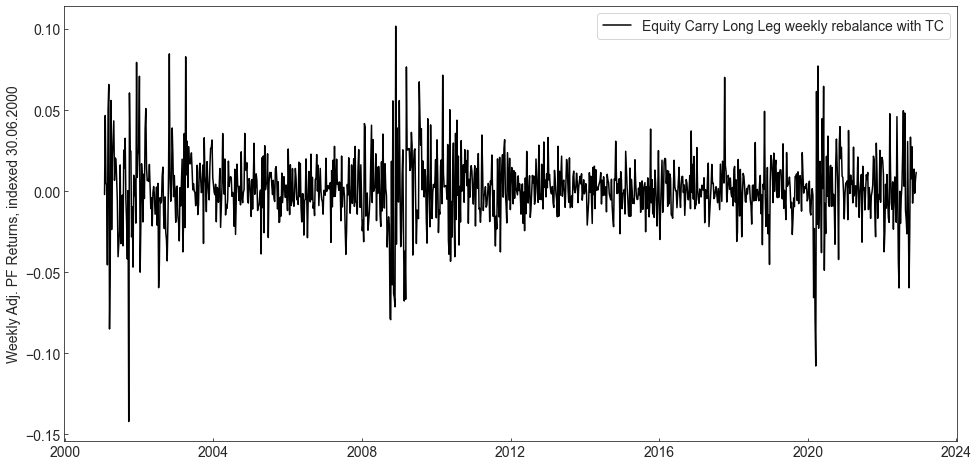

In [15]:
fig, ax = plt.subplots()
ax.plot(total_ret.index,total_ret, label="Equity Carry Long Leg weekly rebalance with TC", color="black")
ax.legend(loc="best")
ax.set_ylabel('Weekly Adj. PF Returns, indexed 30.06.2000')
#plt.savefig("03_Figures/Value_monthly_returns")

In [16]:
pf_ret_unadj = PF_return
pf_ret_unadj_gross = pf_ret_unadj.transform(lambda x: x + 1)
pf_ret_adj_gross = total_ret.transform(lambda x: x + 1)
pf_ret_adj_gross_cum = pf_ret_adj_gross.cumprod() # We don't start at one bc of initial costs for buying pf
pf_ret_unadj_gross_cum = pf_ret_unadj_gross.cumprod() # We don't start at one bc of initial costs for buying pf

Text(0, 0.5, 'Cumulative Returns, indexed 30.06.2000')

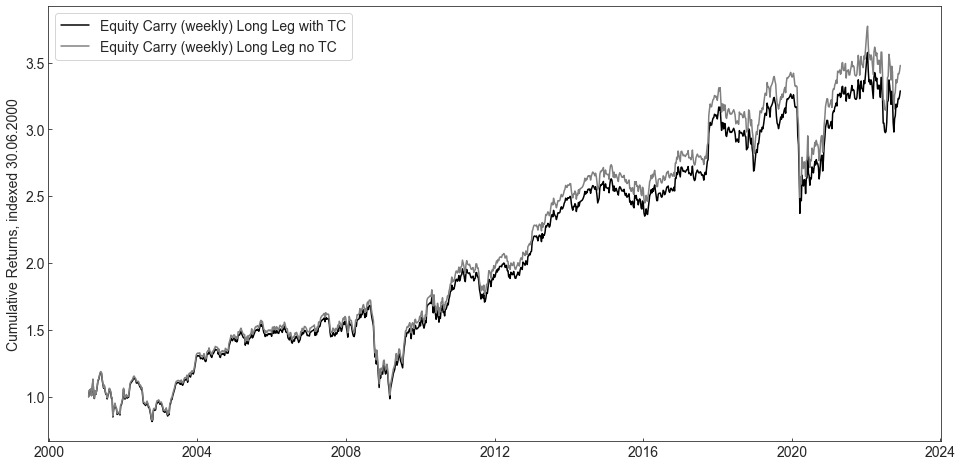

In [17]:
fig, ax = plt.subplots()
ax.plot(pf_ret_adj_gross_cum.index,pf_ret_adj_gross_cum, label="Equity Carry (weekly) Long Leg with TC", color="black")
ax.plot(pf_ret_unadj_gross_cum.index,pf_ret_unadj_gross_cum, label="Equity Carry (weekly) Long Leg no TC", color="grey")
ax.legend(loc="best")
ax.set_ylabel('Cumulative Returns, indexed 30.06.2000')
#plt.savefig("03_Figures/Value_Performance_monthly_rebalance")

### 2

Text(0, 0.5, 'Monthly Adj. PF Returns, indexed 30.06.2000')

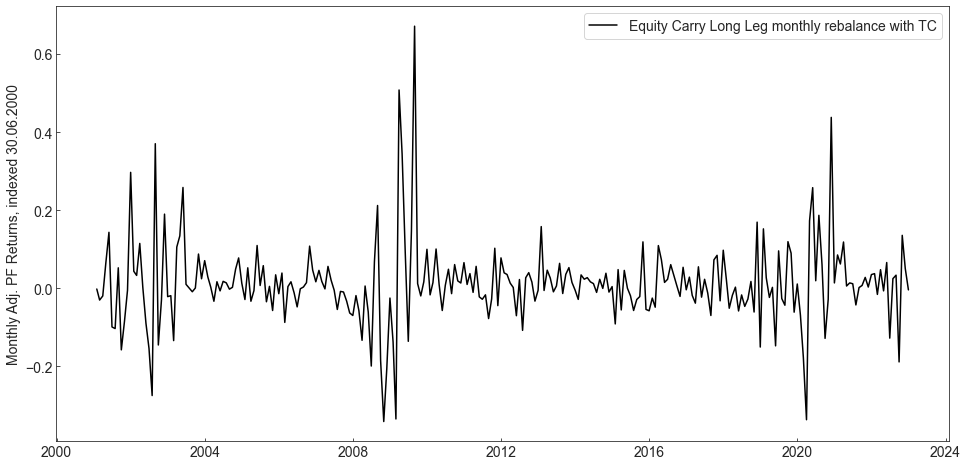

In [31]:
fig, ax = plt.subplots()
ax.plot(total_ret.index,total_ret, label="Equity Carry Long Leg monthly rebalance with TC", color="black")
ax.legend(loc="best")
ax.set_ylabel('Monthly Adj. PF Returns, indexed 30.06.2000')
#plt.savefig("03_Figures/Value_monthly_returns")

In [32]:
pf_ret_unadj = PF_return
pf_ret_unadj_gross = pf_ret_unadj.transform(lambda x: x + 1)
pf_ret_adj_gross = total_ret.transform(lambda x: x + 1)
pf_ret_adj_gross_cum = pf_ret_adj_gross.cumprod() # We don't start at one bc of initial costs for buying pf
pf_ret_unadj_gross_cum = pf_ret_unadj_gross.cumprod() # We don't start at one bc of initial costs for buying pf

Text(0, 0.5, 'Cumulative Returns, indexed 30.06.2000')

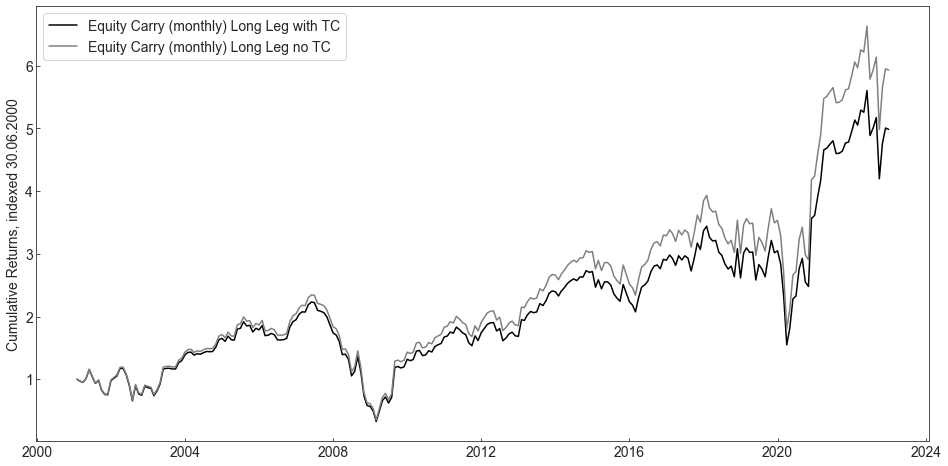

In [33]:
fig, ax = plt.subplots()
ax.plot(pf_ret_adj_gross_cum.index,pf_ret_adj_gross_cum, label="Equity Carry (monthly) Long Leg with TC", color="black")
ax.plot(pf_ret_unadj_gross_cum.index,pf_ret_unadj_gross_cum, label="Equity Carry (monthly) Long Leg no TC", color="grey")
ax.legend(loc="best")
ax.set_ylabel('Cumulative Returns, indexed 30.06.2000')
#plt.savefig("03_Figures/Value_Performance_monthly_rebalance")

### 3

Text(0, 0.5, 'Monthly Adj. PF Returns, indexed 30.06.2000')

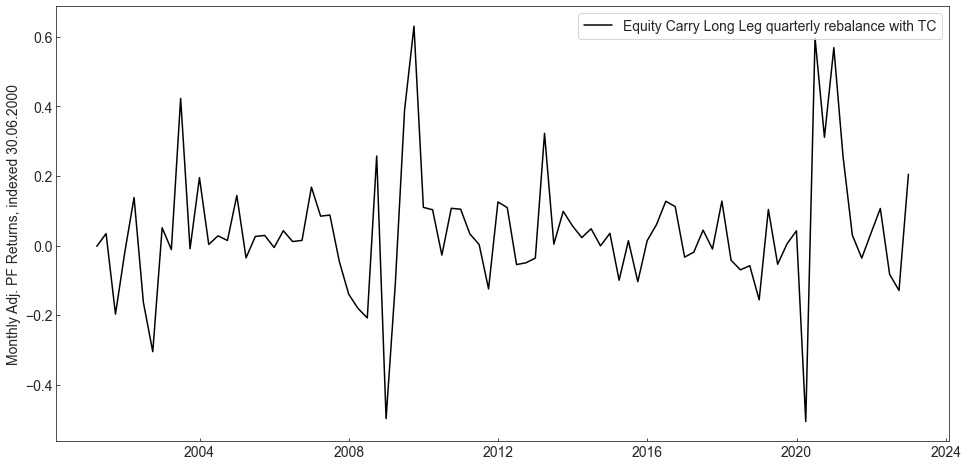

In [47]:
fig, ax = plt.subplots()
ax.plot(total_ret.index,total_ret, label="Equity Carry Long Leg quarterly rebalance with TC", color="black")
ax.legend(loc="best")
ax.set_ylabel('Monthly Adj. PF Returns, indexed 30.06.2000')
#plt.savefig("03_Figures/Value_monthly_returns")

In [48]:
pf_ret_unadj = PF_return
pf_ret_unadj_gross = pf_ret_unadj.transform(lambda x: x + 1)
pf_ret_adj_gross = total_ret.transform(lambda x: x + 1)
pf_ret_adj_gross_cum = pf_ret_adj_gross.cumprod() # We don't start at one bc of initial costs for buying pf
pf_ret_unadj_gross_cum = pf_ret_unadj_gross.cumprod() # We don't start at one bc of initial costs for buying pf

Text(0, 0.5, 'Cumulative Returns, indexed 30.06.2000')

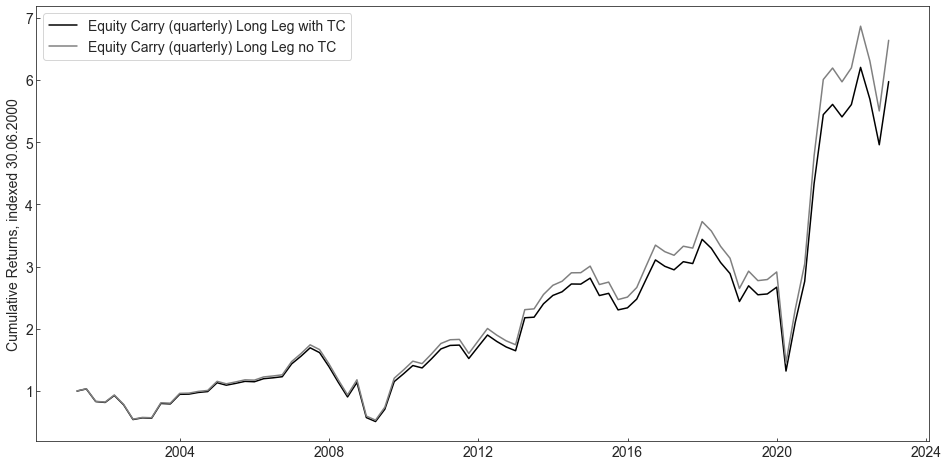

In [49]:
fig, ax = plt.subplots()
ax.plot(pf_ret_adj_gross_cum.index,pf_ret_adj_gross_cum, label="Equity Carry (quarterly) Long Leg with TC", color="black")
ax.plot(pf_ret_unadj_gross_cum.index,pf_ret_unadj_gross_cum, label="Equity Carry (quarterly) Long Leg no TC", color="grey")
ax.legend(loc="best")
ax.set_ylabel('Cumulative Returns, indexed 30.06.2000')
#plt.savefig("03_Figures/Value_Performance_monthly_rebalance")